<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/01-Propagacion-directa-SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 > Redes Neuronales Artificiales - Propagación directa </h1>    

El objetivo de esta notebook es implementar la propagación directa de una red neuronal para realizar predicciones en la tarea de clasificación de dígitos escritos a mano del dataset MNIST.

Para esto, usaremos matrices de pesos precalculados y evaluaremos la tarea de clasificación usando el conjunto de prueba.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Sólo necesitamos el conjunto de prueba del dataset MNIST. **Estamos en el escenario de que el modelo ya está entrenado.**

In [2]:
from keras.datasets import mnist

_, (X_test, y_test) = mnist.load_data()

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

11490434/11490434 [==============================] - 1s 0us/step
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Cargamos la carpeta *data* del repositorio de Github

In [3]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP/trunk/03-Deep-Learning/data/"

A    data/mnist_biases1.npy
A    data/mnist_biases2.npy
A    data/mnist_weights1.npy
A    data/mnist_weights2.npy
Checked out revision 218.


## Clasificación multiclase

Para este ejercicio, usaremos una red neuronal para reconocer los dígitos escritos a mano (de 0 a 9). 

### Conjunto de datos

* Usaremos el conjunto de prueba del dataset MNIST de keras, el cual que contiene 10000 ejemplos de prueba de dígitos escritos a mano (este es un subconjunto del conjunto de datos de dígitos escritos a mano [MNIST] (http://yann.lecun.com/exdb/mnist). 

* Cada ejemplo de prueba es una imagen del dígito en escala de grises de $28\times 28$ píxeles. Cada píxel está representado por un número real que indica la intensidad de la escala de grises en esa ubicación. 

* La cuadrícula de pixeles de $28\times 28$ se *desenrolla* en un vector de 784 dimensiones. Cada uno de estos ejemplos se convierte en una sola fila en nuestra matriz de datos `X`. Esto nos da una matriz $X$ de $10000\times 784$ donde cada fila es una instancia para el clasificador.

$$ X = \begin{bmatrix} - \: (x ^ {(1)})^T \: - \\ - \: (x ^{(2)})^ T \: - \\ \vdots \\ - \: (x ^ {(m)})^ T \: - \end{bmatrix} $$

* Los pesos de la red fueron entrenados en una notebook que usaremos después. Los pesos están almacenados como arreglos de numpy en formato *npy*.

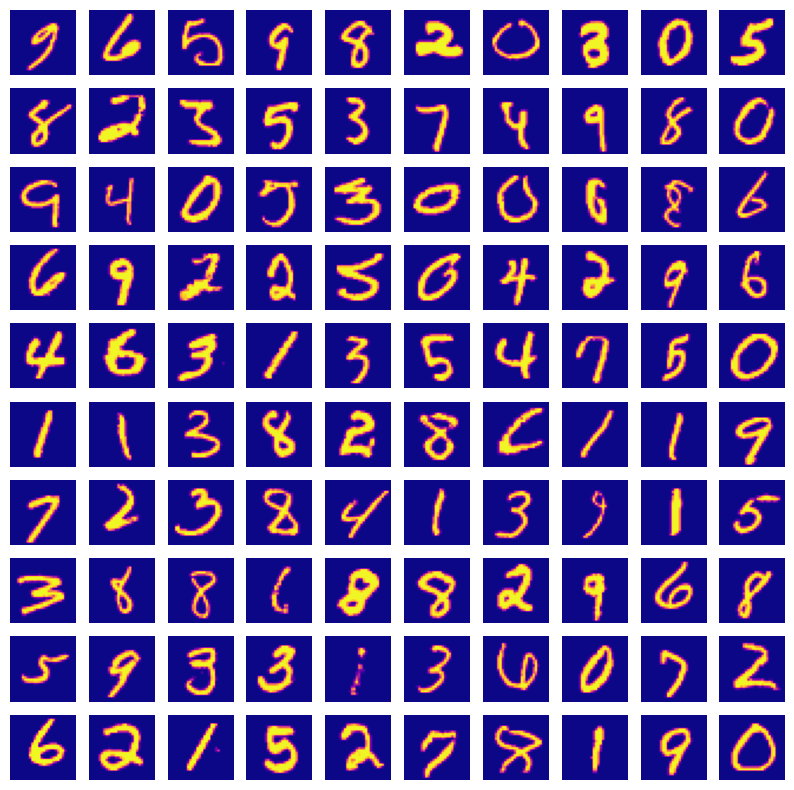

In [4]:
X = X_test.copy()
y = y_test.copy() 

m = y.shape[0] # Número de instancias

indices = np.random.permutation(m)

# ----- Elegimos 100 puntos al azar para desplegar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :].reshape((10,10,-1))

# ----- Visualizamos de los datos
fig, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(sel[i,j].reshape((28,28)),cmap='plasma')          
        axarr[i,j].axis('off')
fig.show()

## Modelo de red neuronal

La red neuronal que vamos a implementar es la siguiente:

<img align="center" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/img/redneuronal.png?raw=1"/> 

Tiene 3 capas: una capa de entrada, una capa oculta y una capa de salida. Recuerda que nuestras entradas son valores de pixeles de imágenes de dígitos. Dado que las imágenes tienen un tamaño de 28 × 28, esto nos da 784 neuronas de capa de entrada (excluyendo la neurona de bias adicional que siempre agrega una entrada). 

Se te ha proporcionado un conjunto de parámetros de la red ($\Theta^{(1)}$, $\Theta^{(2)}$) ya entrenados (fueron generados con el modelo de la siguiente notebook). La siguiente celda carga esos parámetros en `Theta1` y` Theta2`. Los parámetros tienen dimensiones para una red neuronal con 8 neuronas en la segunda capa y 10 neuronas de salida (correspondientes a las clases de cada uno de los 10 dígitos).

### Parámetros para el ejercicio

Cargamos los pesos a partir de arreglos de numpy guardados

In [5]:
weights_1 = np.load('/content/data/mnist_weights1.npy')
weights_2 = np.load('/content/data/mnist_weights2.npy')

biases_1 = np.load('/content/data/mnist_biases1.npy')
biases_2 = np.load('/content/data/mnist_biases2.npy')

In [6]:
print(weights_1.shape)
print(biases_1.shape)
print(weights_2.shape)
print(biases_2.shape)

(784, 8)
(8,)
(8, 10)
(10,)


Juntamos los biases "encima" de los pesos:

$$b=(b_1,...,b_{8})$$

$$W = \left(\begin{array}{ccc}
w_{1,1} & ... & w_{1,8} \\
... & ... & ... \\
w_{784,1} & ... & w_{784,8}
\end{array}\right)$$

para obtener:

$$\Theta_1 = \left(\begin{array}{ccc}
b_1 & ... & b_8 \\
w_{1,1} & ... & w_{1,8} \\
... & ... & ... \\
w_{784,1} & ... & w_{784,8}
\end{array}\right)$$

al final, transponemos y tenemos $\Theta_1^T$.

In [7]:
Theta1 = np.transpose(np.vstack((biases_1,weights_1)))
print(Theta1.shape)

Theta2 = np.transpose(np.vstack((biases_2,weights_2)))
print(Theta2.shape)

(8, 785)
(10, 9)


In [8]:
# Parámetros
neuronas_de_entrada  = 784 
neuronas_ocultas = 8  
etiquetas = 10          # 10 etiquetas, clases de 0 a 9

In [9]:
print(Theta1.shape)
print(Theta2.shape)
print(X.shape)

(8, 785)
(10, 9)
(10000, 28, 28)


## Propagación directa y predicción

* Completa el código en la función predicción para devolver la predicción de la red neuronal. 
* Debes implementar el cálculo directo de $h_{\theta}(x^{(i)})$ para cada ejemplo $i$ y devolver las predicciones asociadas. 
* De acuerdo con la estrategia de clasificación de uno contra todos, la predicción de la red neuronal será la etiqueta que tenga el mayor valor $(h_{\theta}(x^(i)))_k$

### Funciones de activación

In [10]:
def sigmoide(z):
    return 1.0 / (1.0 + np.exp(-z))

### ⭕ Implementa la función `predict`


**Nota de implementación:** La matriz $X$ contiene las instancias en cada fila. Cuando completes el código en la función $predict$, deberás agregar la columna de 1's a la matriz. Las matrices $\text{Theta}_1$ y $\text{Theta}_2$ contienen los parámetros para cada neurona en sus filas. Específicamente, la primera fila de $Theta1$ corresponde a los datos que van a ser procesados por la primera neurona oculta en la segunda capa. En `numpy`, cuando se calcula $z^{(2)}=\Theta^{(1)}a^{(1)}$, hay que asegurarse de indexar (y si es necesario, transponer) $X$ correctamente para obtener $a^{(l)}$ como un vector 1-dimensional.

El vector que debes obtener en la capa de salida es de $10000\times 10$ 

In [24]:
def predict(Theta1, Theta2, X):
    """
    Predice la etiqueta de una entrada dada una red entrenada.
    
    Entradas:
    ----------
    Theta1 : tipo arreglo 
        Pesos para la capa 1 de la red neuronal.
        Tiene shape (2da capa x capa de entrada)
    
    Theta2: tipo arreglo
        Pesos para la capa 2 de la red neuronal.
        Tiene shape (capa de salida x 2da capa)
    
    X : tipo arreglo (matriz)
        Las imágenes de entrada de tamaño (instancias x dimensiones de la imagen).
    
    Salidas: 
    ------
    p : tipo arreglo
        Vector de predicciones con etiquetas predichas para cada ejemplo
        Su tamaño es igual al número de instancias.
    
    """
    # Necesitamos a X 2D
    print(X.shape)
    if X.ndim == 1:
        X = X[None]
    
    # numero de instancias y etiquetas
    m = X.shape[0]
    etiquetas = Theta2.shape[0]

    # Cambiamos a coordenadas homogeneas las entradas de la matriz X
    ones = np.ones((m,1))
    a1 = np.hstack((ones,X))

    """ ====================== TU CODIGO AQUI ======================"""
    z1 = a1@Theta1.T
    a2 = np.tanh(z1)  # Prueba con diferentes funciones de activación (sigmoide o tanh)
    a2 = np.hstack((ones,a2))
    z2 = a2@Theta2.T
    h = np.tanh(z2)
    """ ============================================================="""
    p = np.argmax(h,axis=1) 
    return p

### Prueba el modelo

Aplanamos cada instancia como un vector de $28\times 28=784$ componentes.

In [12]:
X_flatten = X.reshape((X.shape[0],X.shape[1]*X.shape[1]))
X_flatten.shape

(10000, 784)

Realizamos las predicciones. Deberías ver una exactitud de aproximadamente 57%.

In [25]:
pred = predict(Theta1, Theta2, X_flatten)
print(f"Accuracy: {np.mean(pred == y) * 100} %")

(10000, 784)
Accuracy: 79.19 %


In [14]:
pred.shape

(10000,)

### Para visualizar una por una las instancias de entrada y la predicción correspondiente

(784,)
Predición de la Red Neuronal: [2]


<ipython-input-10-7de092398527>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


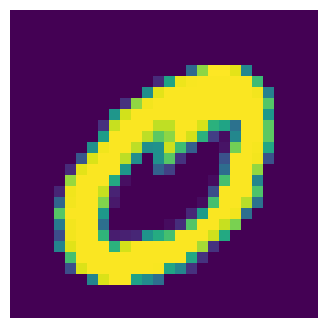

In [19]:
fig,ax = plt.subplots(figsize=(4,4))
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    ax.imshow(X[i,:].reshape((28,28)))          
    ax.axis('off')    
    pred = predict(Theta1, Theta2, X_flatten[i, :])
    print(f'Predición de la Red Neuronal: {pred}')
else:
    print('No hay más imágenes.')

##¿Qué pasa si usamos una matriz de pesos sin entrenar?

Creamos matrices aleatorias de pesos, de la misma forma que las matrices de pesos que usamos.

In [20]:
weights1_shape = Theta1.shape
weights2_shape = Theta2.shape

random_weights1 = np.random.randn(*weights1_shape)
random_weights2 = np.random.randn(*weights2_shape)

Calculamos el accuracy

In [21]:
pred = predict(random_weights1, random_weights2, X_flatten)
print(f"Accuracy: {np.mean(pred == y) * 100} %")

(10000, 784)
Accuracy: 9.07 %


<ipython-input-10-7de092398527>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Observamos algunos ejemplos de predicciones

In [ ]:
# ------ Obtenemos algunos índices aleatorios:
some_idxs = np.random.choice(list(range(y.shape[0])),size=6,replace=False)

fig, axes = plt.subplots(ncols=6, sharex=False,
			 sharey=True, figsize=(10, 4))
for i,idx in enumerate(some_idxs):
	axes[i].set_title(pred[idx],fontsize=15)
	axes[i].imshow(X[idx], cmap='gray')
	axes[i].get_xaxis().set_visible(False)
	axes[i].get_yaxis().set_visible(False)
plt.show()